In [1]:
import gensim.models.keyedvectors as word2vec 
from nltk.tokenize import RegexpTokenizer

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report



import os

Using TensorFlow backend.


In [2]:
# get the current working directory
data_path = os.path.abspath(os.path.join(os.path.dirname( '__file__' ), '..', 'Datasets'))+'/'

# Although the dataset says csv, it is tab delimited. In addition to this, they have severe codels problems. 
# So best to parse throught codes first. 
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 2: invalid start byte

#open for reading with "universal" type set

import codecs

doc_d_t = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_drug_target'+'.csv','rU','UTF-8') 
EUADR_drug_target = pd.read_csv(doc_d_t, sep='\t', na_filter = False)
EUADR_drug_target['CLASS'] = 'drug_gene'

doc_t_d = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_target_disease'+'.csv','rU','UTF-8',errors='ignore') 
EUADR_target_disease = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
EUADR_target_disease['CLASS'] = 'gene_disease'
       
doc_d_d = codecs.open(data_path+'EUADR_Corpus_IBIgroup/'+'EUADR_drug_disease'+'.csv','rU','UTF-8')                       
EUADR_drug_disease = pd.read_csv(doc_d_d, sep='\t', na_filter = False)
EUADR_drug_disease['CLASS'] = 'drug_disease'


EUADR_temp = EUADR_drug_target.append(EUADR_target_disease).append(EUADR_drug_disease)

EUADR_temp_1 = EUADR_temp[EUADR_temp['ASSOCIATION_TYPE'] == 'PA']
EUADR_temp_2 = EUADR_temp[EUADR_temp['ASSOCIATION_TYPE'] == 'NA']
EUADR_temp = EUADR_temp_1.append(EUADR_temp_2)

In [3]:
# Get GAD dataset

doc_t_d = codecs.open(data_path+'GAD_Corpus_IBIgroup/'+'GAD_Y_N'+'.csv','rU','UTF-8',errors='ignore') 
GAD_target_disease_Y_N = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
GAD_target_disease_Y_N['CLASS'] = 'gene_disease'

doc_t_d = codecs.open(data_path+'GAD_Corpus_IBIgroup/'+'GAD_F'+'.csv','rU','UTF-8',errors='ignore') 
GAD_target_disease_F = pd.read_csv(doc_t_d, sep='\t', na_filter = False)
GAD_target_disease_F['CLASS'] = 'gene_disease'

GAD_temp = GAD_target_disease_Y_N


In [4]:
# Get PolySearch dataset
ColNames = ['entity_1', 'entity_2', 'Association', 'PMID','Sentence']
Poly_doc_d_t = codecs.open(data_path+'PolySearch/'+'p1_disease_gene_testset.simple'+'.tsv','rU','UTF-8') 
Poly_target_disease = pd.read_csv(Poly_doc_d_t, sep='\t', na_filter = False, names = ColNames)
Poly_target_disease['CLASS'] = 'gene_disease'

In [5]:
from bs4 import BeautifulSoup
import lxml
import pandas as pd

infile = open(data_path+'CoMAGC/'+'CoMAGC.xml','r')
contents = infile.read()
soup = BeautifulSoup(contents,'lxml')

annotations = soup.find_all('annotation_unit')


CoMAGClist = []

for each_sentence in annotations:
    sentence = each_sentence.find('sentence').text
    label_ = each_sentence.find('expression_change_keyword_2')
    label = label_['type'].split('_')[0]
#     print(sentence + '----' + label)
    try:
        CoMAGClist.append({'SENTENCE': sentence, 'ASSOCIATION': label})
    except:
        pass

CoMAGClist_temp = pd.DataFrame(CoMAGClist)    

In [6]:
CoMAGClist_temp.to_csv(data_path+'CoMAGC.csv')

PA    1098
NA     282
dtype: int64


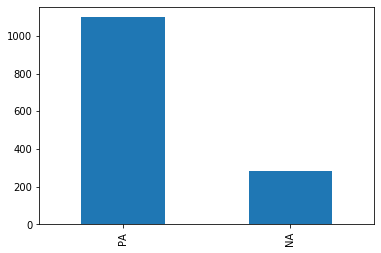

In [7]:
# get sentences and their associations

# sentences = EUADR_temp['SENTENCE'].append(GAD_temp['GAD_CONCLUSION'])
# labels = EUADR_temp['ASSOCIATION_TYPE'].append(GAD_temp['GAD_ASSOC'].apply(lambda x: x.replace('Y', 'PA').replace('N', 'NA').replace('F', 'FA')))

sentences = EUADR_temp['SENTENCE'].append(CoMAGClist_temp['SENTENCE'])
labels = EUADR_temp['ASSOCIATION_TYPE'].append(CoMAGClist_temp['ASSOCIATION'].apply(lambda x: x.replace('Positive', 'PA').replace('Negative', 'NA').replace('Gene', 'NA')))


labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())



In [8]:
from sklearn import preprocessing
from keras.utils import np_utils

le = preprocessing.LabelEncoder()

le.fit(labels)
le.classes_
# le.inverse_transform()

y = le.transform(labels)
dummy_y = np_utils.to_categorical(y)


In [9]:
def format_sentences(a_list_of_sentences):
    
#     tkr = RegexpTokenizer('[a-zA-Z@]+')
    sentences_split = []

    for i, line in enumerate(a_list_of_sentences):
        #print(line)
        sent = str(line).split()
#         sent = tkr.tokenize(str(sent))
        sentences_split.append(sent)
        
    return sentences_split

sentences_split = format_sentences(sentences)
print(sentences_split[710])



['In', 'a', 'murine', 'prostate', 'tumour', 'model,', 'infusion', 'of', 'recombinant', 'HGF', 'resulted', 'in', 'an', 'increase', 'in', 'the', 'levels', 'of', 'both', 'BMPR-IB', 'and', 'BMPR-II', 'transcript', 'in', 'prostate', 'tumours.']


In [10]:
w2vModel = word2vec.KeyedVectors.load_word2vec_format('/home/stirunag/pre-trained_word_embeddings/PubMed-and-PMC-w2v.bin', binary=True, limit=1000000)
# w2vModel = word2vec.KeyedVectors.load_word2vec_format('/home/stirunag/pre-trained_word_embeddings/PubMed-and-PMC-w2v.bin', binary=True)
#Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_split)
X = tokenizer.texts_to_sequences(sentences_split)

#lenght of sentence to consider
maxlenth = 10
#add padding
X = pad_sequences(X, maxlen=maxlenth)
print(X.shape)

#create a embedding layer using PMC vectors (100000 words)
embedding_layer = Embedding(input_dim=w2vModel.wv.vectors.shape[0], output_dim=w2vModel.wv.vectors.shape[1], weights=[w2vModel.wv.vectors], 
                            input_length=X.shape[1])



/home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app
W0730 17:11:06.263839 140618515212032 deprecation_wrapper.py:119] From /home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



(1380, 10)


In [11]:
#create model

lstm_out = 32

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=lstm_out))
# model.add(Dense(1, activation='softmax'))
model.add(Dense(2, activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


W0730 17:11:08.580862 140618515212032 deprecation_wrapper.py:119] From /home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 17:11:08.587901 140618515212032 deprecation_wrapper.py:119] From /home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 17:11:08.609659 140618515212032 deprecation_wrapper.py:119] From /home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0730 17:11:08.611105 140618515212032 deprecation_wrapper.py:119] From /home/stirunag/anaconda3/envs/KerasCPU/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.Conf

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 200)           200000000 
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 200,029,890
Trainable params: 200,029,890
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
from sklearn.model_selection import train_test_split

#split dataset
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= 0.1, random_state = 24, stratify=y)
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size= 0.2, random_state = 24, stratify=y)

#fit model
batch_size = 512
model.fit(X_train, Y_train, epochs=25, verbose=1, batch_size=batch_size)

#analyze the results
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)

Epoch 1/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.5431 - acc: 0.7953
Epoch 2/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.5117 - acc: 0.7953
Epoch 3/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4937 - acc: 0.7953
Epoch 4/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4863 - acc: 0.7953
Epoch 5/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4874 - acc: 0.7953
Epoch 6/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4814 - acc: 0.7953
Epoch 7/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4670 - acc: 0.7953
Epoch 8/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4545 - acc: 0.7953
Epoch 9/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4418 - acc: 0.7953
Epoch 10/25
1104/1104 [==============================] - 6s 5ms/step - loss: 0.4320 - acc: 0.7953
Epoch 11/25
1104/1104 [======

In [14]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')  
# f1_score(Y_test, y_pred, average='micro')  

# f1_score(Y_test, y_pred.round(), average='macro')



0.8254009583944638

In [20]:
#Let us test some  samples
# test_samples = ["The human T1663A GH1 gene polymorphism, which may confer lower levels of GH and IGF-I, appears to be associated with a decreased risk of colorectal cancer."]
# test_samples = ["Individuals who bear GSTT1 0/0 genotype or GSTT1 0/0-GSTM1 0/0 combined genotypes are more susceptible to leukemia, especially for male and younger carriers."]
# test_samples = ["We found no evidence that mutation in GUCA1B,GNGT1,or RGS9 gene is a cause of retinitis pigmentosa."]
test_samples = ['These results suggest that HLA class I antigens and TNF-alpha A-308G are not associated with susceptibility or resistance to the development of TDI-induced asthma.']
# test_samples = ['The results suggest that the studied dinucleotide repeat polymorphism of the ER alpha gene may contribute to specific components of personality.']

test_sample_split = format_sentences(test_samples)
test_ = tokenizer.texts_to_sequences(test_sample_split)
test_pad = pad_sequences(test_, maxlen=maxlenth)
#predict
# model.predict(x=test_pad)

dic = dict(zip(le.classes_, model.predict(x=test_pad).tolist()[0]))

dic

{'NA': 0.0015690014697611332, 'PA': 0.9984310269355774}

In [ ]:
from keras.models import model_from_json

result_path = os.path.abspath(os.path.join(os.path.dirname( '__file__' ), '..', 'Results'))+'/models/'

# serialize model to JSON
model_json = model.to_json()
with open(result_path+"sentiment_association_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(result_path+"sentiment_association_model.h5")
print("Saved model weights to disk")

model.save(result_path+"model_and_architecture_sentiment_association_model.h5")
print("Saved architecture model and architecture model to disk")

In [18]:
# from keras.models import model_from_json

# result_path = os.path.abspath(os.path.join(os.path.dirname( '__file__' ), '..', 'Results'))+'/models/'

# # # load json and create model
# json_file = open(result_path+'sentiment_association_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights(result_path+"sentiment_association_model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# score = loaded_model.evaluate(X, dummy_y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [17]:
test_samples = ['CCBE1 is expressed in normal ovary, but is reduced in ovarian cancer cell lines and primary carcinomas.']

test_sample_split = format_sentences(test_samples)
test_ = tokenizer.texts_to_sequences(test_sample_split)
test_pad = pad_sequences(test_, maxlen=maxlenth)
#predict
# model.predict(x=test_pad)

dic = dict(zip(le.classes_, model.predict(x=test_pad).tolist()[0]))

dic

{'NA': 0.055498842149972916, 'PA': 0.9445011615753174}

In [28]:
# Testing on unseen data

ColNames = ['entity_1', 'entity_2', 'Association', 'PMID', 'Sentence']
Poly_doc_d_t = codecs.open(data_path+'PolySearch/'+'p1_disease_gene_testset.simple'+'.tsv','rU','UTF-8') 
Poly_target_disease = pd.read_csv(Poly_doc_d_t, sep='\t', na_filter = False, names = ColNames)
Poly_target_disease['CLASS'] = 'gene_disease'

# Poly_doc_d_t = codecs.open(data_path+'PolySearch/'+'p1_drug_gene_testset'+'.tsv','rU','UTF-8') 
# Poly_drug_target = pd.read_csv(Poly_doc_d_t, sep='\t', na_filter = False, names = ColNames)
# Poly_drug_target['CLASS'] = 'drug_gene'


# Poly_temp = Poly_drug_target.append(Poly_target_disease)

Poly_temp = Poly_target_disease

# Poly_temp

PA    341
NA    181
Name: Association, dtype: int64


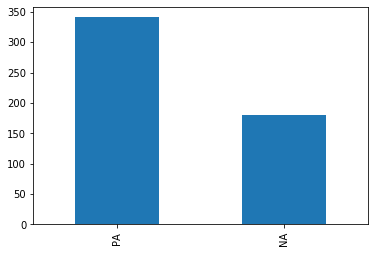

In [29]:
test_sentences = Poly_temp['Sentence']
test_labels = Poly_temp['Association'].apply(lambda x: x.replace('Negative', 'NA').replace('Positive', 'PA'))

labels_count = test_labels.value_counts()
labels_count.plot(kind="bar")
print(test_labels.value_counts())

In [30]:
test_sentences_split = format_sentences(test_sentences)
# len(test_sentences_split)
test_sequences = tokenizer.texts_to_sequences(test_sentences_split)
test_pad = pad_sequences(test_sequences, maxlen=maxlenth)
y_pred = model.predict(x=test_pad)

In [31]:
f1_score(le_tr, y_pred.argmax(axis=1), average='weighted')  

NameError: name 'y_test' is not defined